In [18]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

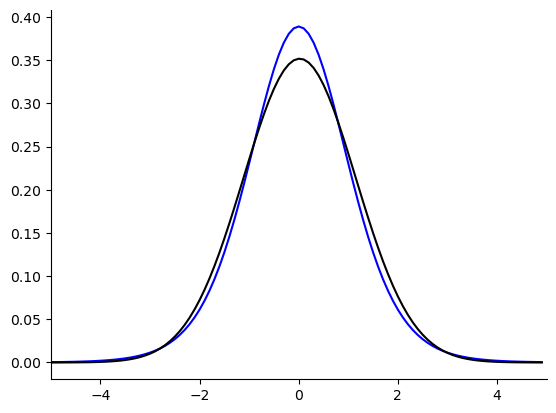

In [3]:
x = np.arange(-5, 5, 0.1)
tdist = stats.t(df=10)

y_t = tdist.pdf(x)
y_norm = stats.norm(*stats.norm.fit(tdist.rvs(10_000))).pdf(x)

fig, ax = plt.subplots()
ax.plot(x, y_t, color="blue")
ax.plot(x, y_norm, color="k")
ax.set_xlim(-5, 5)
sns.despine()

# Analytical Test

In [4]:
df = sns.load_dataset("tips")
male = df.query("sex == 'Male'")["tip"].values
female = df.query("sex == 'Female'")["tip"].values

In [5]:
diff_in_means = male.mean() - female.mean()
pooled_sd = np.hstack([male, female]).std()
SE = pooled_sd * np.sqrt(1/len(male) + 1/len(female))

print(f"{diff_in_means = :.3f}")
print(f"{pooled_sd = :.3f}")
print(f"{SE = :.3f}")
print(f"{diff_in_means / SE = :.4f}")



diff_in_means = 0.256
pooled_sd = 1.381
SE = 0.185
diff_in_means / SE = 1.3881


In [6]:
stats.ttest_ind(male, female, alternative="greater")

Ttest_indResult(statistic=1.387859705421269, pvalue=0.08322811751728378)

# Resampling Test

<AxesSubplot:ylabel='Density'>

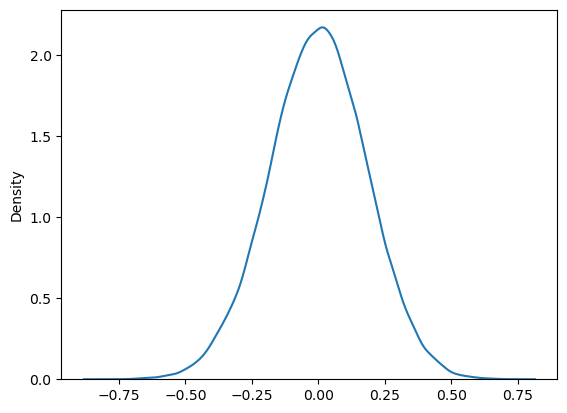

In [7]:
all_ppl = np.hstack([male, female])

re_male = np.random.choice(all_ppl, size=(100_000, len(male)))
re_female = np.random.choice(all_ppl, size=(100_000, len(female)))

diffs = re_male.mean(axis=1) - re_female.mean(axis=1)
sns.kdeplot(diffs)


In [8]:
(diffs > diff_in_means).mean()

0.08006

In [9]:
1 - stats.rv_histogram(np.histogram(diffs, bins=50)).cdf(diff_in_means)

0.08009347118502563

# GLMs

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import GammaRegressor, LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [11]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [12]:
transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), ["sex", "time", "day", "smoker"])
], remainder="passthrough")

pipeline = Pipeline([
    ("transform", transformer),
    ("model", GammaRegressor())
    #("model", LinearRegression())
])

In [13]:
pipeline.fit(df.drop("tip", axis=1), df["tip"])

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  ['sex', 'time', 'day',
                                                   'smoker'])])),
                ('model', GammaRegressor())])

mae = 0.7704402703218418, mse = 1.0602396219498618


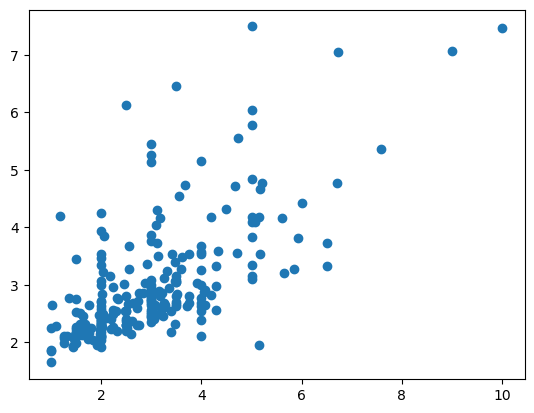

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

preds = pipeline.predict(df.drop("tip", axis=1))

mae = mean_absolute_error(df.tip, preds)
mse = mean_squared_error(df.tip, preds)

print(f"{mae = }, {mse = }")
plt.scatter(df.tip, preds);

<AxesSubplot:>

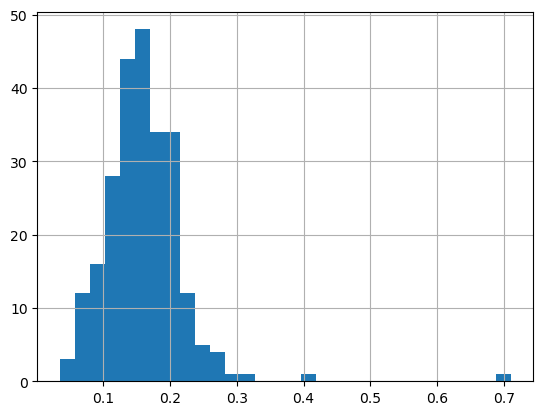

In [15]:
df.eval("tip / total_bill").hist(bins=30)

In [16]:
np.exp(pipeline["model"].coef_.reshape(1, -1) @ transformer.transform(df.drop("tip", axis=1)).T + pipeline["model"].intercept_)

array([[2.64557097, 2.19466642, 3.04834361, 3.24081048, 3.48652884,
        3.55156795, 2.04764438, 3.72978688, 2.48374193, 2.46393562,
        2.14444447, 4.84271221, 2.51297637, 2.87526461, 2.47532726,
        3.03787048, 2.20074325, 2.63597284, 2.70003575, 2.94751499,
        2.65355907, 2.86324548, 2.49120977, 5.36530552, 2.81344505,
        2.75799078, 2.30663708, 2.25883901, 2.98112815, 2.80736922,
        2.05065426, 2.80423566, 2.43733431, 3.02303465, 2.64214391,
        3.27385701, 2.57878402, 2.63658115, 2.77487826, 4.08773512,
        2.55743215, 2.67590305, 2.40101904, 2.10583545, 4.15679673,
        2.74517725, 3.09928874, 4.42085037, 3.8450343 , 2.72412488,
        2.29970793, 2.1523697 , 4.77606886, 2.12276318, 3.5812198 ,
        2.84851564, 5.14125142, 3.45704069, 2.16184586, 7.0461204 ,
        2.85663683, 2.33988577, 2.1472497 , 2.80119367, 2.68245885,
        2.89623048, 2.54392491, 1.6511257 , 2.8491911 , 2.42796753,
        2.21271268, 2.64797228, 3.50795177, 3.34

# F-Test

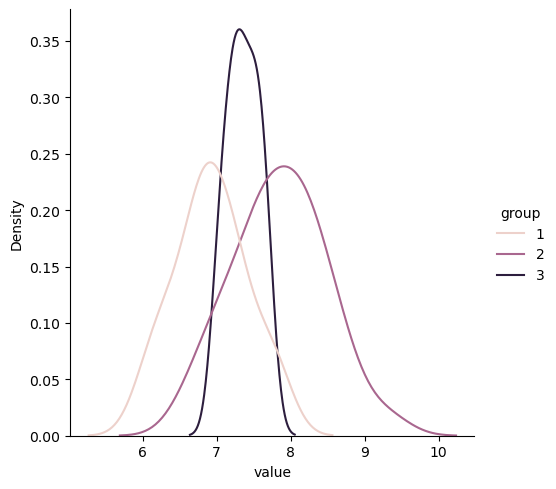

In [34]:
np.random.seed(42)
g1 = np.random.normal(loc=7, scale=0.5, size=24)
g2 = np.random.normal(loc=8, scale=0.7, size=31)
g3 = np.random.normal(loc=7.3, scale=0.25, size=19)
data = pd.DataFrame({"group": [1] * len(g1) + [2] * len(g2) + [3] * len(g3), "value": np.hstack([g1, g2, g3])})
sns.displot(data=data, x="value", hue="group", kind="kde")

In [38]:
stats.f_oneway(g1, g2, g3)

F_onewayResult(statistic=22.962072436076816, pvalue=2.0373807359987896e-08)

observed_stat = 0.21486120559396013
p-value = 0.0001


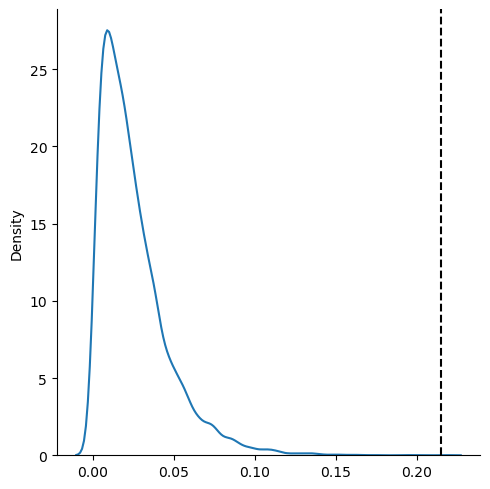

In [76]:
all_data = np.hstack([g1, g2, g3])
re_g1 = np.random.choice(all_data, size=(10_000, len(g1))).mean(axis=1)
re_g2 = np.random.choice(all_data, size=(10_000, len(g2))).mean(axis=1)
re_g3 = np.random.choice(all_data, size=(10_000, len(g3))).mean(axis=1)

grand_mean = data["value"].mean()

variances = ((np.hstack([re_g1.reshape(-1, 1), re_g2.reshape(-1, 1), re_g3.reshape(-1, 1)]) - grand_mean) ** 2).sum(axis=1) / (3 - 1)

observed_stat = ((g1.mean() - grand_mean) ** 2 + (g2.mean() - grand_mean) ** 2 + (g3.mean() - grand_mean) ** 2) / (3 - 1)
print(f"{observed_stat = }")
print(f"p-value = {(variances > observed_stat).mean()}")
sns.displot(variances, kind="kde")
plt.axvline(observed_stat, color="k", ls="--");